# Data Storytelling: Craigslist Listings


## Context

Data source citation: 

Reese, Austin (June 2020). USA Housing Listings: Homes for Sale within the United States, Version 3. Retrieved April 12th, 2021 from: https://www.kaggle.com/austinreese/usa-housing-listings

Cragislist is a classified advertisments site where users can post items for sale as various as furniture, appliances, and even property. The dataset cited above holds Craigslist posts advertising property for the month of June 2020. A classic regression problem is immediately obvious: using the features to predict the price. However, since this assignment is focused on data storytelling, I will not be training a model to predict prices. Instead, I will approach this data from an exploratory point of view. What questions can I ask to uncover interesting and perhaps unexpected relationships between data points? What story do these relationships tell?

## Exploration and Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

%matplotlib inline

In [2]:
housing_df = pd.read_csv("housing.csv")
housing_df.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca
2,7043634882,https://reno.craigslist.org/apa/d/sparks-state...,reno / tahoe,https://reno.craigslist.org,1813,apartment,1683,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00t0t_erYqC6LgB8...,2BD | 2BA | 1683SQFTDiscover exceptional servi...,39.6269,-119.708,ca
3,7049045324,https://reno.craigslist.org/apa/d/reno-1x1-fir...,reno / tahoe,https://reno.craigslist.org,1095,apartment,708,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00303_3HSJz75zlI...,MOVE IN SPECIAL FREE WASHER/DRYER WITH 6 OR 12...,39.4477,-119.771,ca
4,7049043759,https://reno.craigslist.org/apa/d/reno-no-long...,reno / tahoe,https://reno.craigslist.org,289,apartment,250,0,1.0,1,...,1,0,1,laundry on site,NaN,https://images.craigslist.org/01616_fALAWFV8zQ...,"Move In Today: Reno Low-Cost, Clean & Furnishe...",39.5357,-119.805,ca


In [3]:
# drop unneeded columns
housing_df = housing_df.drop(["url", "region_url", "image_url", "description"], axis=1)

In [4]:
housing_df.head()

,id,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,state
0,7049044568,reno / tahoe,1148,apartment,1078,3,2.0,1,1,0,0,0,0,w/d in unit,carport,39.5483,-119.796,ca
1,7049047186,reno / tahoe,1200,condo,1001,2,2.0,0,0,0,0,0,0,w/d hookups,carport,39.5026,-119.789,ca
2,7043634882,reno / tahoe,1813,apartment,1683,2,2.0,1,1,1,0,0,0,w/d in unit,attached garage,39.6269,-119.708,ca
3,7049045324,reno / tahoe,1095,apartment,708,1,1.0,1,1,1,0,0,0,w/d in unit,carport,39.4477,-119.771,ca
4,7049043759,reno / tahoe,289,apartment,250,0,1.0,1,1,1,1,0,1,laundry on site,NaN,39.5357,-119.805,ca


In [5]:
housing_df.shape

(384977, 18)

In [6]:
housing_df.dtypes

id                           int64
region                      object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
lat                        float64
long                       float64
state                       object
dtype: object

In [7]:
# check that all ids are unique
housing_df.id.nunique() == housing_df.shape[0]

True

In [8]:
# check for missing values
housing_df.isna().any()

id                         False
region                     False
price                      False
type                       False
sqfeet                     False
beds                       False
baths                      False
cats_allowed               False
dogs_allowed               False
smoking_allowed            False
wheelchair_access          False
electric_vehicle_charge    False
comes_furnished            False
laundry_options             True
parking_options             True
lat                         True
long                        True
state                      False
dtype: bool

In [9]:
# get rid of rows with any missing values
housing_df = housing_df.dropna(axis=0)
housing_df.shape

(235970, 18)

In [10]:
# get state names and abbreviations
state_names = []
state_abbr = []
with open("states.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        state_names.append(line.split(", ")[0])
        state_abbr.append(line.split(", ")[1].strip().lower())

In [11]:
# add state names to dataframe
states_df = pd.DataFrame({"state":state_abbr, "name":state_names})
housing_df = pd.merge(housing_df, states_df, on="state", how="left")
housing_df = housing_df.rename({"state":"state_abbr", "name":"state"}, axis=1)

In [12]:
# find the number of states and the five most popular
print("There are", housing_df.state.nunique(), "states.")
housing_df.state.value_counts()[:5]

There are 51 states.


California    24175
Texas         15542
Florida       15232
Michigan       9834
Ohio           9246
Name: state, dtype: int64

In [13]:
# find the number of regions and the five most popular
print("There are", housing_df.region.nunique(), "regions.")
housing_df.region.value_counts()[:5]

There are 404 regions.


rochester                 2888
jacksonville              2549
columbus                  2178
omaha / council bluffs    2025
minneapolis / st paul     2016
Name: region, dtype: int64

In [14]:
# list the values in categorical features 
# excluding state and region as those have been explored already
cat_feats = housing_df.select_dtypes(include="object").columns.to_list()
cat_feats.remove('state')
cat_feats.remove('region')
cat_feats.remove('state_abbr')
for cat in cat_feats:
  print(cat+":")
  print(housing_df[cat].value_counts())
  print()

type:
apartment          186097
house               22219
townhouse           12869
condo                4711
duplex               4490
manufactured         3820
cottage/cabin         598
loft                  554
flat                  458
in-law                144
land                    8
assisted living         2
Name: type, dtype: int64

laundry_options:
w/d in unit           102302
w/d hookups            54485
laundry on site        44419
laundry in bldg        31409
no laundry on site      3355
Name: laundry_options, dtype: int64

parking_options:
off-street parking    125105
attached garage        38670
carport                38478
detached garage        16356
street parking         15362
no parking              1857
valet parking            142
Name: parking_options, dtype: int64



In [15]:
# check the value counts of boolean features
bool_feats = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 
              'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']
for b in bool_feats:
  print(b+":")
  print(housing_df[b].value_counts())
  print()

cats_allowed:
1    183895
0     52075
Name: cats_allowed, dtype: int64

dogs_allowed:
1    177721
0     58249
Name: dogs_allowed, dtype: int64

smoking_allowed:
1    151726
0     84244
Name: smoking_allowed, dtype: int64

wheelchair_access:
0    211392
1     24578
Name: wheelchair_access, dtype: int64

electric_vehicle_charge:
0    231829
1      4141
Name: electric_vehicle_charge, dtype: int64

comes_furnished:
0    222232
1     13738
Name: comes_furnished, dtype: int64



In [16]:
# check the statistics for numerical features
pd.set_option('display.float_format', lambda x: '%.3f' % x)
num_feats = ['price', 'sqfeet', 'beds', 'baths']
for num in num_feats:
  print(num+":")
  print(housing_df[num].describe())
  print()

price:
count       235970.000
mean         13511.263
std        5699285.850
min              0.000
25%            819.000
50%           1059.000
75%           1464.000
max     2768307249.000
Name: price, dtype: float64

sqfeet:
count    235970.000
mean       1105.269
std       24367.855
min           0.000
25%         750.000
50%         950.000
75%        1154.000
max     8388607.000
Name: sqfeet, dtype: float64

beds:
count   235970.000
mean         1.928
std          3.901
min          0.000
25%          1.000
50%          2.000
75%          2.000
max       1100.000
Name: beds, dtype: float64

baths:
count   235970.000
mean         1.479
std          0.628
min          0.000
25%          1.000
50%          1.000
75%          2.000
max         75.000
Name: baths, dtype: float64



There are some pretty large outliers evident by looking at the maximum values of each feature: a $2 billion price tag, over 8 million sqft of space, 75 bathrooms, and 1,100 rooms. These are likely errors. I will remove any values more than 5 standard deviations from the mean. 

The minimum of the "price" feature is 0. This is likely an error as well. I will remove those rows. 

In [17]:
# remove rows with 0s in price column
print("There are", sum(housing_df.price==0), "properties with $0 price.")
housing_df = housing_df[housing_df.price>0]
print("Properties with $0 price removed. There are", sum(housing_df.price==0) 
,"properties with $0 price.")

There are 903 properties with $0 price.
Properties with $0 price removed. There are 0 properties with $0 price.


In [18]:
# remove values 5 standard deviations from the mean
for feat in num_feats:
  housing_df = housing_df[housing_df[feat] < \
                          housing_df[feat].mean()+(housing_df[feat].std()*5)]

In [19]:
# Create a feature for the price per square feet: price_per_sqft
housing_df["price_per_sqft"] = housing_df["price"]/housing_df["sqfeet"]

## Visualization

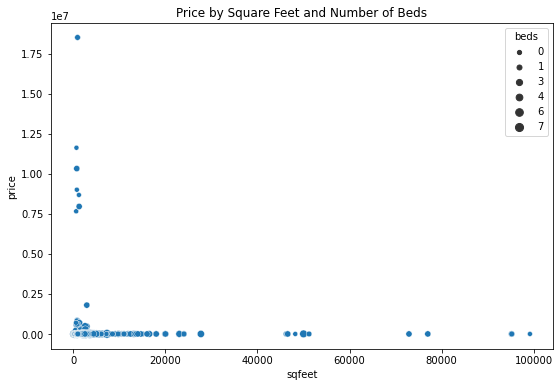

In [20]:
plt.subplots(figsize=(9,6))
sns.scatterplot(x="sqfeet", y="price", size="beds", data=housing_df)
plt.title("Price by Square Feet and Number of Beds")
plt.show();

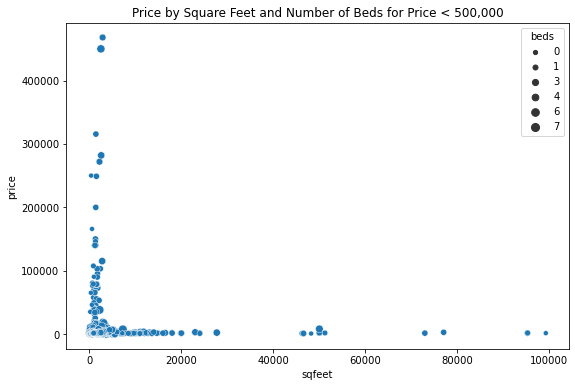

In [21]:
# visualise without outliers
plt.subplots(figsize=(9,6))
no_outliers = housing_df[housing_df["price"]<5*10**5]
sns.scatterplot(x="sqfeet", y="price", size="beds", data=no_outliers)
plt.title("Price by Square Feet and Number of Beds for Price < 500,000")
plt.show();

From this visualization, we see that surprisingly, even when controlling for outliers, having a more beds or more squarefeet is NOT a determinant of price. Let's look at a correlation map to see which columns are correlated:

In [22]:
housing_df = housing_df.astype({
    "id":str,
    "cats_allowed":bool,
    "dogs_allowed":bool,
    "smoking_allowed":bool,
    "wheelchair_access":bool,
    "electric_vehicle_charge":bool,
    "comes_furnished":bool,
    "lat":object,
    "long":object,
})

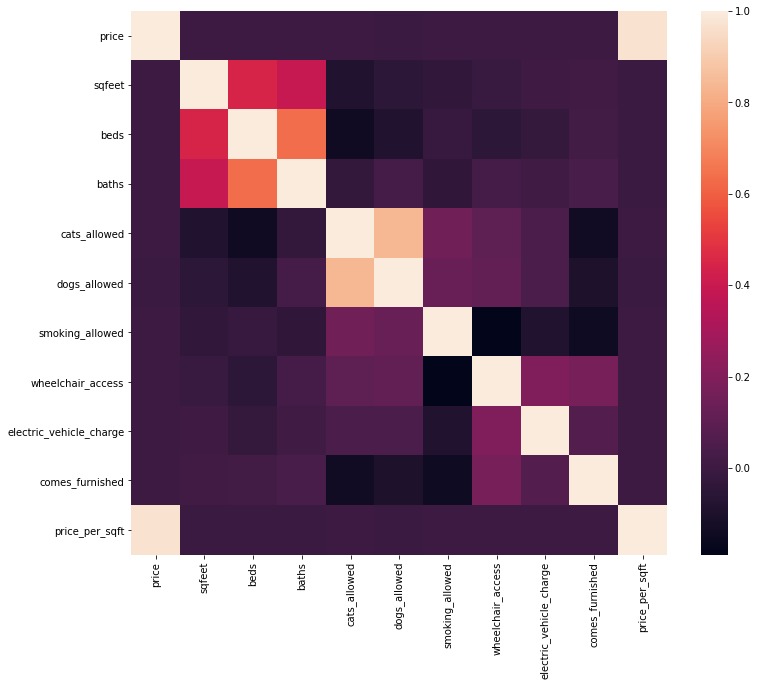

In [23]:
plt.subplots(figsize=(12,10))
sns.heatmap(housing_df.corr());

As shown in the scatterplot, price is not correlated with squarefeet or number of beds/baths. However, the amount of squarefeet is correlated with the number of beds/baths. There are no other strong correlations besides the cats_allowed and dogs_allowed correlation, which was expected as well. 

Correlation maps only deal with numerical data. Are there other features that are closely correlated with price? Let's take a look at the average price for each type of housing:

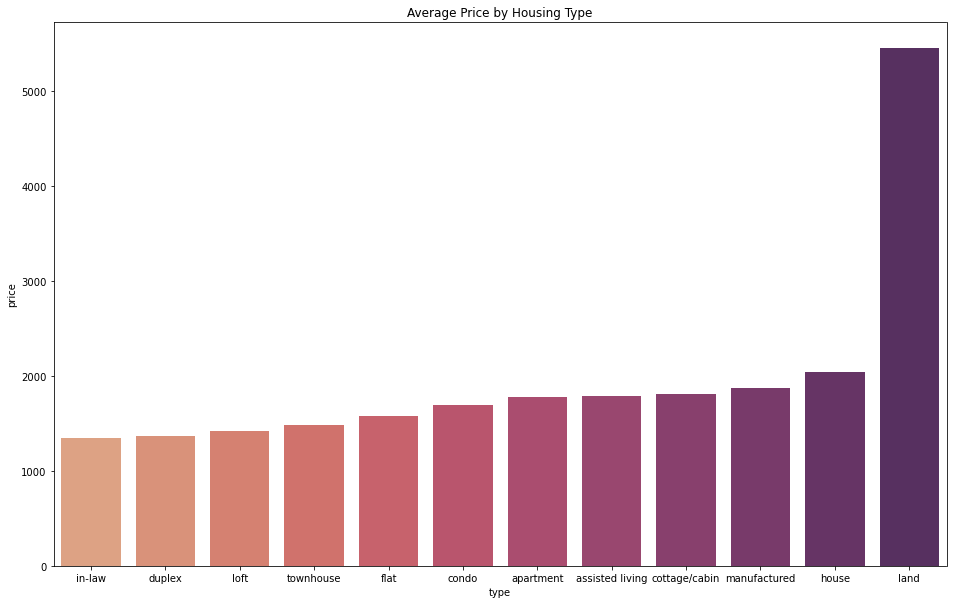

In [24]:
plt.subplots(figsize=(16,10))
data = housing_df.groupby(by="type").price.mean().sort_values()
sns.barplot(x=data.index, y=data, palette="flare")
plt.title("Average Price by Housing Type")
plt.show();

Now, let's look at price by location: 

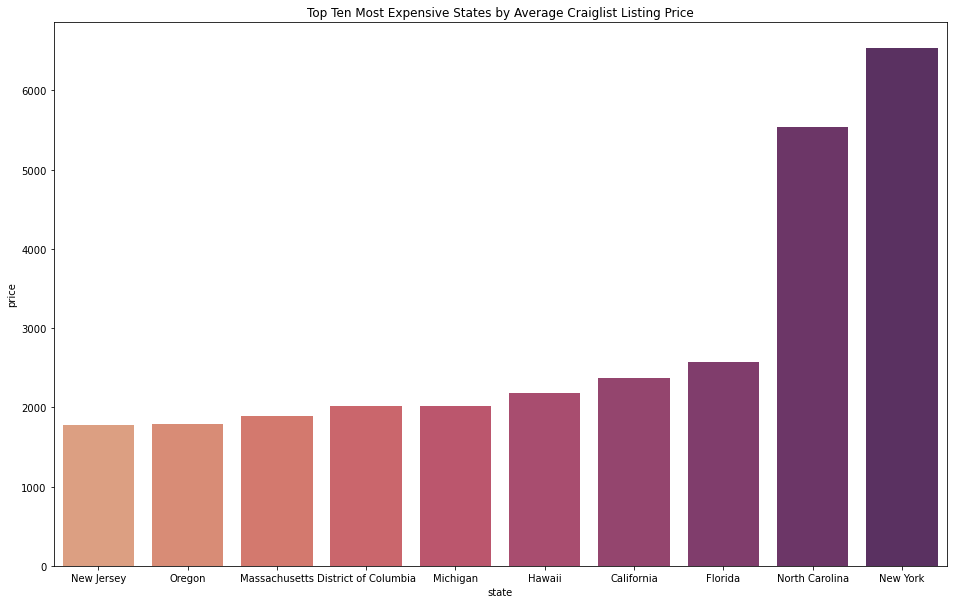

In [25]:
plt.subplots(figsize=(16,10))
data = housing_df.groupby(by="state").price.mean().sort_values()[-10:]
sns.barplot(x=data.index, y=data, palette="flare")
plt.title("Top Ten Most Expensive States by Average Craiglist Listing Price")
plt.show();

Let's visualize the entire country using a map in Tableau:

note: I took a picture of the map instead of embedding the Tableau visualization because Tableau would not render on Github. 

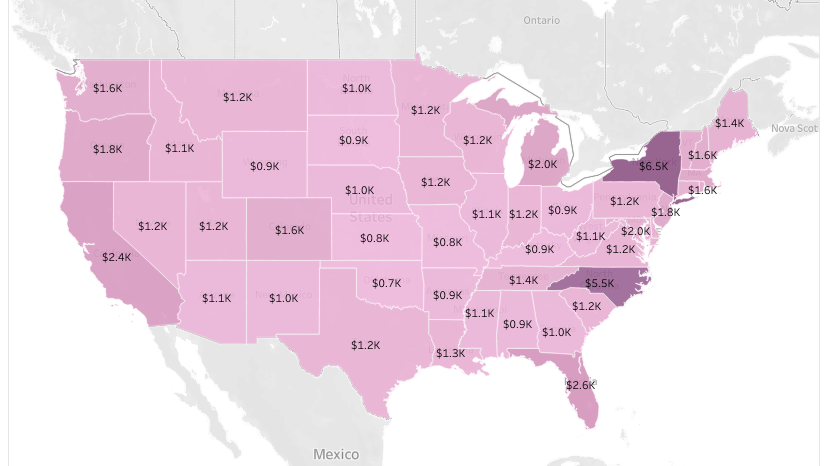

In [26]:
from IPython import display
display.Image("tableau_map.png")

It looks like type and state, not the square feet or number of beds/baths, are the most significant determinants of price. 

If we control for type and state, what other factors do we see contributing to cost? Let's look at apartments in New York: 

In [27]:
ny_apts = housing_df[(housing_df["state"]=="New York") & (housing_df["type"]=="apartment")]

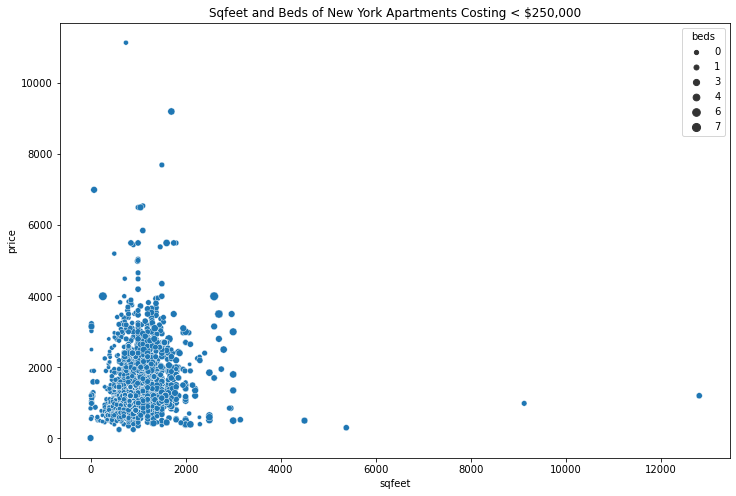

In [28]:
plt.subplots(figsize=(12,8))
sns.scatterplot(x="sqfeet", y="price", size="beds", data=ny_apts[ny_apts["price"]<2.5*10**6])
plt.title("Sqfeet and Beds of New York Apartments Costing < $250,000")
plt.show();

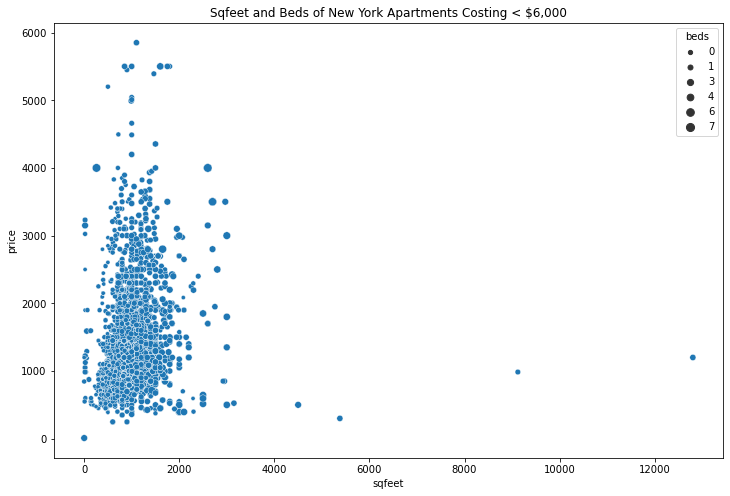

In [29]:
# Zoom in even closer 
plt.subplots(figsize=(12,8))
sns.scatterplot(x="sqfeet", y="price", size="beds", data=ny_apts[ny_apts["price"]<6000])
plt.title("Sqfeet and Beds of New York Apartments Costing < $6,000")
plt.show();

Interestingly, the New York apartments data seems to follow the trend in the overall data. As shown in the correlation map, there is not a direct linear relationship between price and squarefeet or number of bedrooms for the properties in this dataset.  

Now let's visualize some other features. Let's take a look at the locations that have electric vehicles:

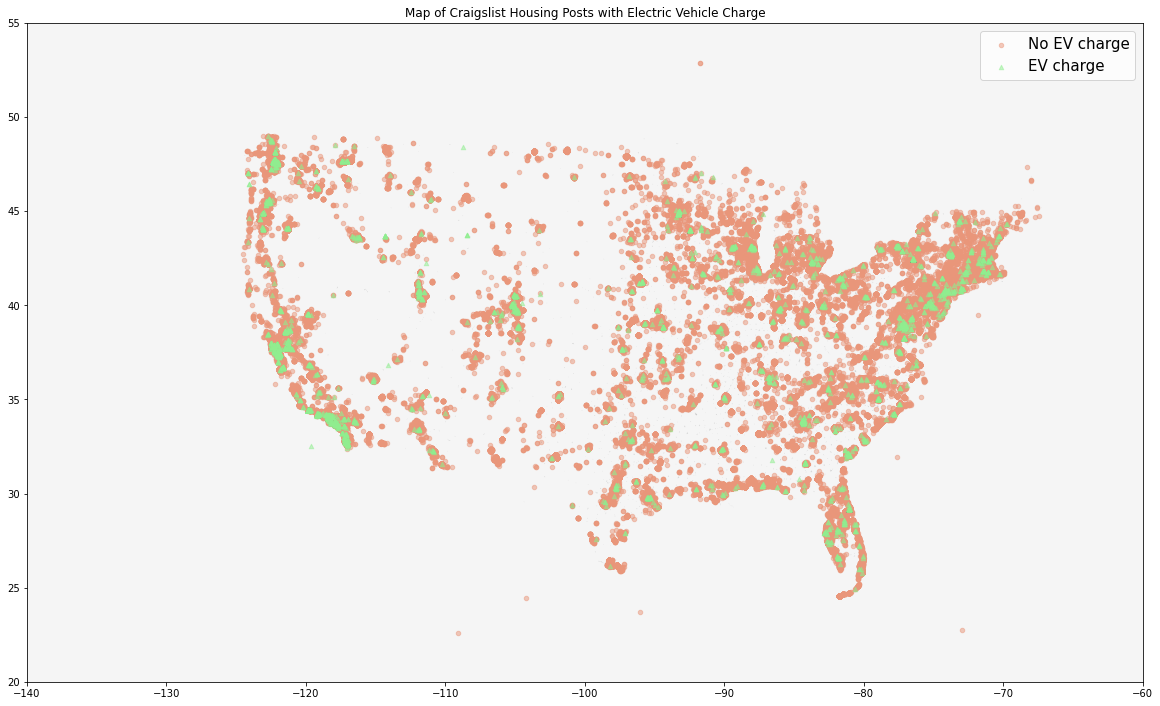

In [30]:
# get coordinates
coordinates = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
geo_df = gpd.GeoDataFrame(housing_df, crs="epsg:4236", geometry=coordinates)

# plot map
fig, ax = plt.subplots(figsize=(20,20))
country_map = gpd.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
country_map.plot(ax=ax, alpha=0.4, color="gray")
ax.set_xlim(-140, -60)
ax.set_ylim(20, 55)
ax.set_facecolor('whitesmoke')

# plot locations without EV charge
geo_df[geo_df["electric_vehicle_charge"]==0].plot(ax=ax, markersize=20, alpha=0.5,
                                                  color="darksalmon", marker="o", label="No EV charge")

# plot locations with EV charge
geo_df[geo_df["electric_vehicle_charge"]==1].plot(ax=ax, markersize=20, alpha=0.5,
                                                  color="lightgreen", marker="^", label="EV charge")

plt.legend(prop={"size":15})
plt.title("Map of Craigslist Housing Posts with Electric Vehicle Charge")
plt.show();

In [31]:
housing_df.electric_vehicle_charge.value_counts()

False    230665
True       4137
Name: electric_vehicle_charge, dtype: int64

There are some offerings with electric vehicle charge included on the property throughout the US, with the coasts having a higher density of properties with this feature. 

Now, let's visualise the locations that allow cats, dogs, and both:

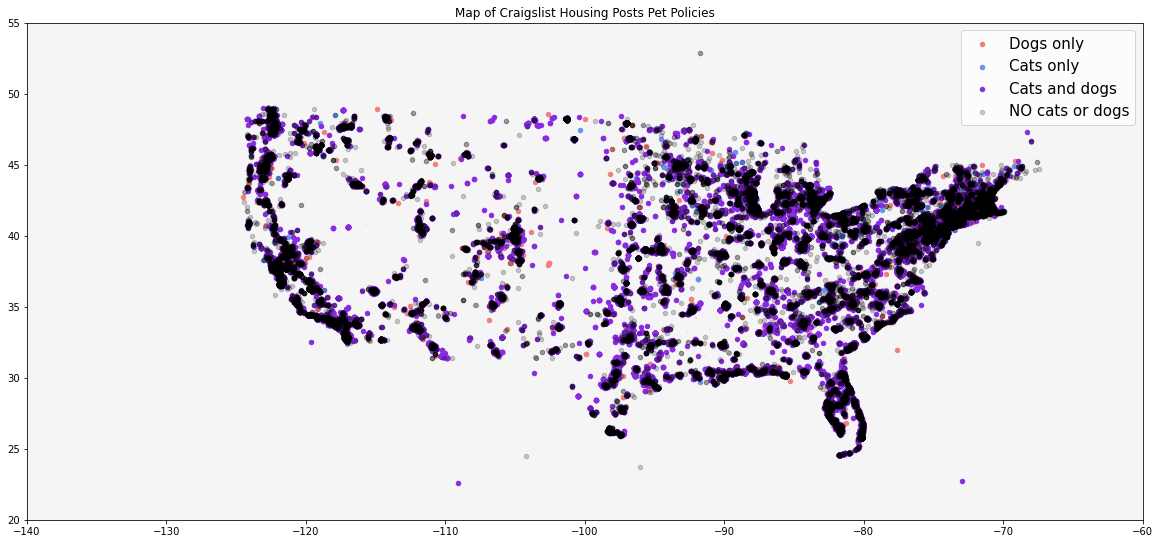

In [32]:
# get coordinates
coordinates = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
geo_df = gpd.GeoDataFrame(housing_df, crs="epsg:4236", geometry=coordinates)

# plot map
fig, ax = plt.subplots(figsize=(20,20))
country_map = gpd.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
country_map.plot(ax=ax, alpha=0.4, color="gray")
ax.set_xlim(-140, -60)
ax.set_ylim(20, 55)
ax.set_facecolor('whitesmoke')


dogs_allowed = geo_df["dogs_allowed"]==1
cats_allowed = geo_df["cats_allowed"]==1

# plot locations that allow only dogs
geo_df[dogs_allowed&(~cats_allowed)].plot(ax=ax, markersize=20, color="lightcoral",
                                                 marker="o", label="Dogs only")


# plot locations that allow only cats
geo_df[cats_allowed&(~dogs_allowed)].plot(ax=ax, markersize=20, color="cornflowerblue",
                                                 marker="o", label="Cats only")
       
# plot locations that allow both cats and dogs
geo_df[cats_allowed&dogs_allowed].plot(ax=ax, markersize=20, color="blueviolet",
                                                 marker="o", label="Cats and dogs")
       
    
# plot locations with no cats or dogs
geo_df[~cats_allowed&(~dogs_allowed)].plot(ax=ax, markersize=20, color="black", alpha=0.2, 
                                                 marker="o", label="NO cats or dogs")

plt.legend(prop={"size":15})
plt.title("Map of Craigslist Housing Posts Pet Policies")
plt.show();

In [33]:
housing_df.cats_allowed.value_counts()

True     183284
False     51518
Name: cats_allowed, dtype: int64

In [34]:
housing_df.dogs_allowed.value_counts()

True     177076
False     57726
Name: dogs_allowed, dtype: int64

It looks like for most housing posts that allow pets, both cats and dogs are allowed. But most properties do not allow pets. 

Same visualization, but with smoking this time: 

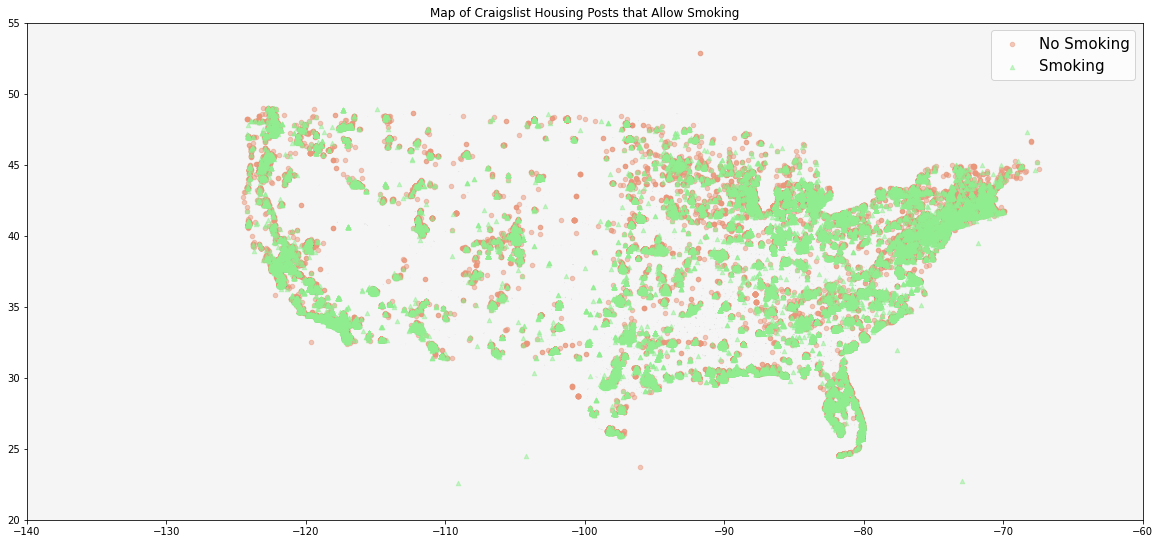

In [35]:
# get coordinates
coordinates = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
geo_df = gpd.GeoDataFrame(housing_df, crs="epsg:4236", geometry=coordinates)

# plot map
fig, ax = plt.subplots(figsize=(20,20))
country_map = gpd.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
country_map.plot(ax=ax, alpha=0.4, color="gray")
ax.set_xlim(-140, -60)
ax.set_ylim(20, 55)
ax.set_facecolor('whitesmoke')

# plot locations that do NOT allow smoking
geo_df[geo_df["smoking_allowed"]==0].plot(ax=ax, markersize=20, alpha=0.5,
                                                  color="darksalmon", marker="o", label="No Smoking")

# plot locations that do allow smoking
geo_df[geo_df["smoking_allowed"]==1].plot(ax=ax, markersize=20, alpha=0.5,
                                          color="lightgreen", marker="^", label="Smoking")

plt.legend(prop={"size":15})
plt.title("Map of Craigslist Housing Posts that Allow Smoking")
plt.show();

In [36]:
housing_df.smoking_allowed.value_counts()

True     151057
False     83745
Name: smoking_allowed, dtype: int64

Most residences allow smoking, and there does not appear to be a strong distinction with regards to region. 

Same visualization, but with wheelchair access:

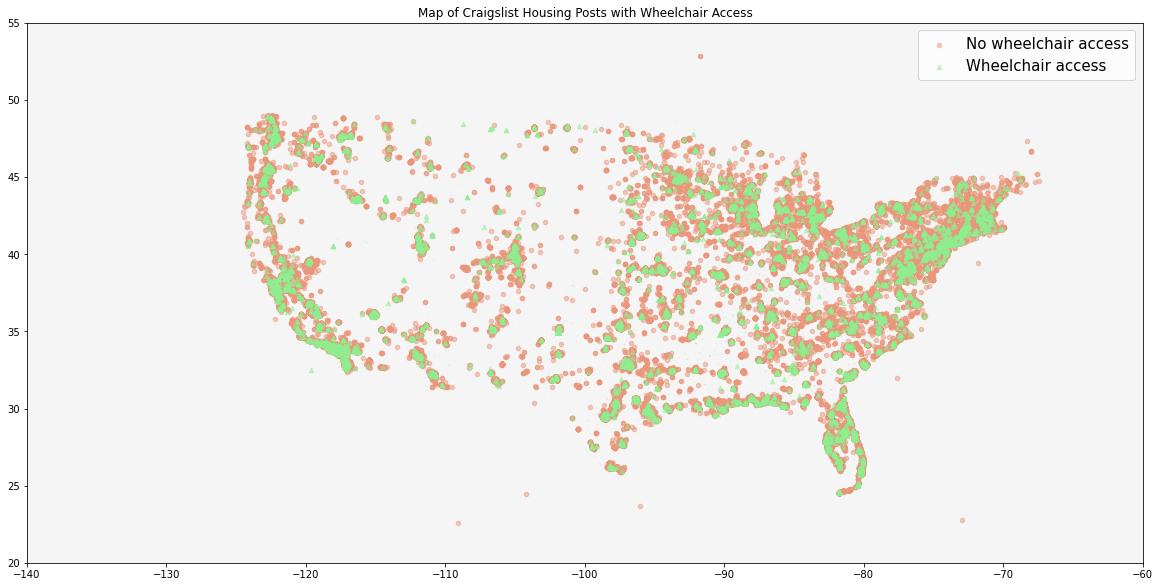

In [37]:
# get coordinates
coordinates = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
geo_df = gpd.GeoDataFrame(housing_df, crs="epsg:4236", geometry=coordinates)

# plot map
fig, ax = plt.subplots(figsize=(20,20))
country_map = gpd.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
country_map.plot(ax=ax, alpha=0.4, color="gray")
ax.set_xlim(-140, -60)
ax.set_ylim(20, 55)
ax.set_facecolor('whitesmoke')

# plot locations without wheelchair access
geo_df[geo_df["wheelchair_access"]==0].plot(ax=ax, markersize=20, alpha=0.5,
                                                  color="darksalmon", marker="o", label="No wheelchair access")

# plot locations with wheelchair access
geo_df[geo_df["wheelchair_access"]==1].plot(ax=ax, markersize=20, alpha=0.5,
                                            color="lightgreen", marker="^", label="Wheelchair access")

plt.legend(prop={"size":15})
plt.title("Map of Craigslist Housing Posts with Wheelchair Access")
plt.show();

In [38]:
housing_df.wheelchair_access.value_counts()

False    210365
True      24437
Name: wheelchair_access, dtype: int64

And finally, a map of residences that come furnished:

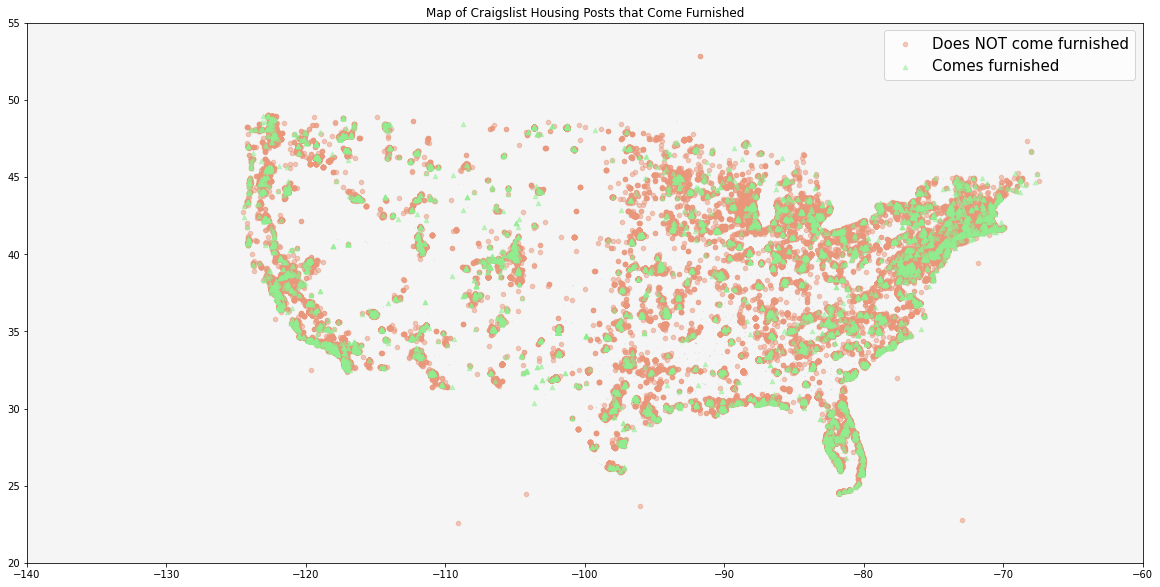

In [39]:
# get coordinates
coordinates = [Point(xy) for xy in zip(housing_df["long"], housing_df["lat"])]
geo_df = gpd.GeoDataFrame(housing_df, crs="epsg:4236", geometry=coordinates)

# plot map
fig, ax = plt.subplots(figsize=(20,20))
country_map = gpd.read_file("cb_2018_us_ua10_500k/cb_2018_us_ua10_500k.shp")
country_map.plot(ax=ax, alpha=0.4, color="gray")
ax.set_xlim(-140, -60)
ax.set_ylim(20, 55)
ax.set_facecolor('whitesmoke')

# plot locations without furnishing
geo_df[geo_df["comes_furnished"]==0].plot(ax=ax, markersize=20, alpha=0.5,
                                                  color="darksalmon", marker="o", label="Does NOT come furnished")

# plot locations with furnishing
geo_df[geo_df["comes_furnished"]==1].plot(ax=ax, markersize=20, alpha=0.5,
                                          color="lightgreen", marker="^", label="Comes furnished")

plt.legend(prop={"size":15})
plt.title("Map of Craigslist Housing Posts that Come Furnished")
plt.show();

In [40]:
housing_df.comes_furnished.value_counts()

False    221318
True      13484
Name: comes_furnished, dtype: int64

For the laundry features, we should limit our view to a specific type in order to get meaningful results. Let's take a look at apartment laundry options and their prices using a violinplot:

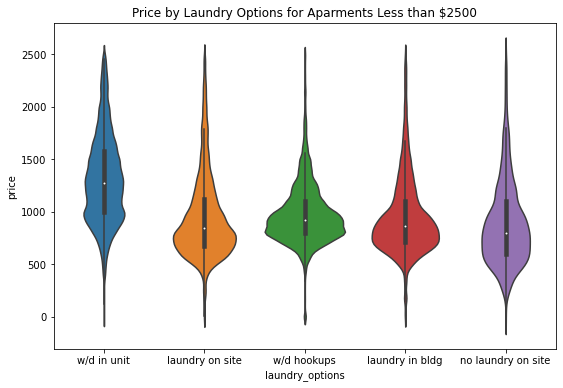

In [41]:
plt.subplots(figsize=(9,6))
trim_outliers = housing_df[housing_df["price"]<.25*10**4]
apartments = trim_outliers[trim_outliers["type"]=="apartment"]
sns.violinplot(x="laundry_options", y="price", data=apartments)
plt.title("Price by Laundry Options for Aparments Less than $2500")
plt.show();

Apartments with a washer and dryer in-unit are the most expensive, as expected. Let's do the same plot, but this time visualising the parking options for apartments:

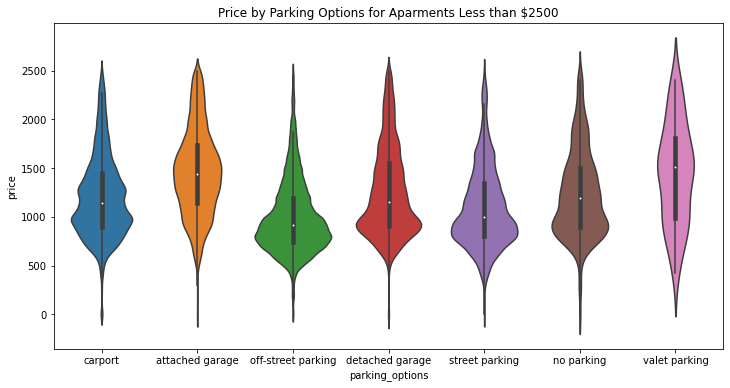

In [42]:
plt.subplots(figsize=(12,6))
trim_outliers = housing_df[housing_df["price"]<.25*10**4]
apartments = trim_outliers[trim_outliers["type"]=="apartment"]
sns.violinplot(x="parking_options", y="price", data=apartments)
plt.title("Price by Parking Options for Aparments Less than $2500")
plt.show();

As expected, valet parking is the most expensive, and also appears to be the least common option for apartments in this price range. 

Let's look at the price by type and state using a PairGrid:

In [43]:
# set state as index, type as columns, and values as prices
pairplot_df = pd.pivot_table(data=housing_df, index="state", values="price", columns="type", aggfunc="mean")

# fill in any missing values with 0
pairplot_df.fillna(0, inplace=True)

# drop any columns except for the top 5 in terms of value count
pairplot_df = pairplot_df[list(housing_df.type.value_counts()[:5].index)]

# get overall prices
pairplot_df["overall"] = housing_df.groupby(by="state").price.mean()

# reset the index to put the state as a column
pairplot_df = pairplot_df.reset_index()

# set column order
order = ["overall"]
order.extend(list(housing_df.type.value_counts()[:5].index))
order.append("state")
pairplot_df = pairplot_df[order]

pairplot_df.head()

type,overall,apartment,house,townhouse,condo,duplex,state
0,902.648,895.109,1079.359,860.407,966.429,854.412,Alabama
1,1223.805,1058.430,1703.474,1558.942,1480.114,1446.241,Alaska
2,1058.737,1007.163,1531.385,1291.532,1278.100,1048.845,Arizona
3,907.327,884.511,1115.270,1034.017,1116.250,881.697,Arkansas
4,2368.339,2384.724,2459.381,2160.180,2347.316,1791.591,California


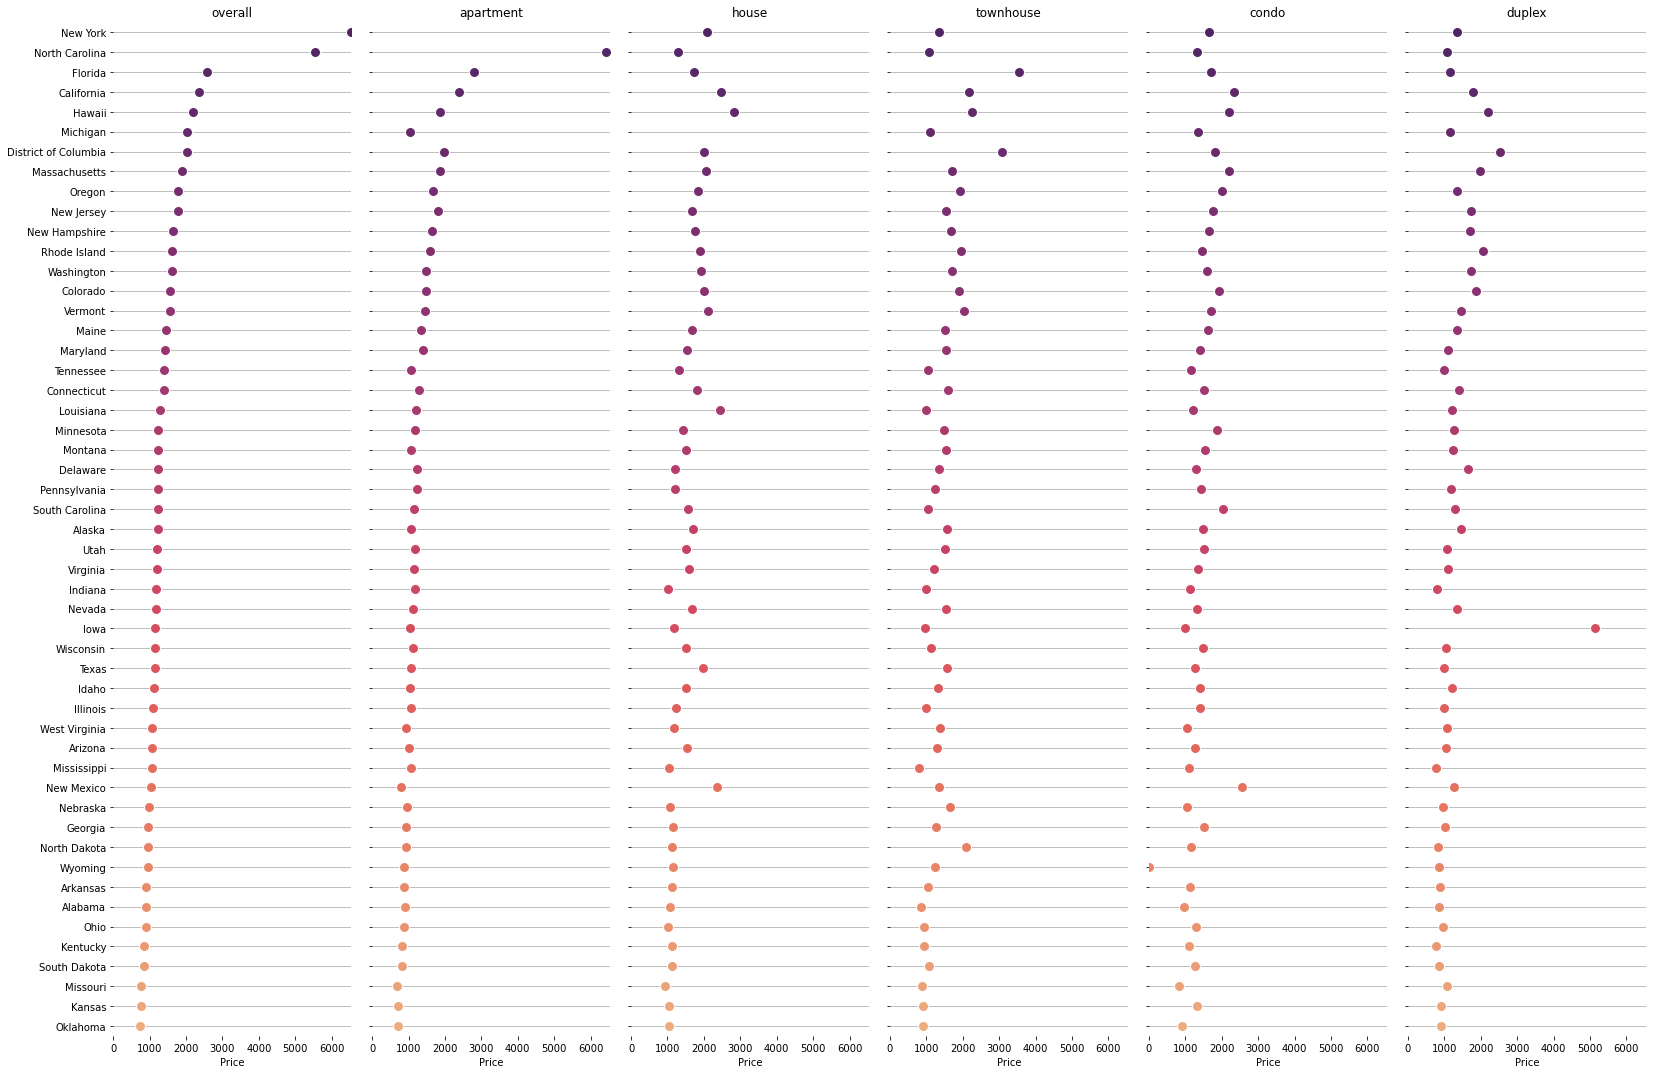

In [44]:
# Make the PairGrid
g = sns.PairGrid(pairplot_df.sort_values("overall", ascending=False),
                 x_vars=list(pairplot_df.columns[:-1]), y_vars=["state"],
                 height=15, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, max(pairplot_df.overall)), xlabel="Price", ylabel="")

# Use semantically meaningful titles for the columns
titles = list(pairplot_df.columns[:-1])

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## Conclusions

* Price and squarefeet are not correlated, which goes against my original expectation. 
* The type of property and the state it is located in appear to be the most important determinants of price. 
* Surprisingly, North Carolina is the second most expensive state, after New York. This is not necessarily reflective of national trends, as this is only Craigslist data from one month, June 2020. 
* It is rare to find a property with an electric charge installed, but you have a better chance if you are looking for a property in the North East or California. 
* Most properties that allow cats also allow dogs, but most properties allow neither. 
* Smoking is allowed at most properties, with no obvious trends based on state alone. 
* Most properties do not have wheelchair access.
* Of the furnished properties, most are either in California, the North East, or Florida. 
* For apartments, having a washer and dryer in-unit will cost the most on average. 
* For apartments, off-street parking is cheapest and valet parking is most expensive, on average. 
* Apartments tend to follow the general trend of the overall price for property types per state: if the average price of all properties in a state is high, the average cost for an apartment is likely to also be high. A few notable exceptions (in this dataset) are Florida, California, Hawaii, and Michigan. There is quite a bit more variation for the remaining types of the five most popular property types (house, townhouse, condo, duplex.)